# Injection recovery through bilby

Inject a signal through pycbc and recover with bilby

In [1]:
import bilby
import numpy as np

import matplotlib.pyplot as plt
import config

config.conf_matplolib()

# Load injection polarization data

In [2]:
inj_fd_data = np.genfromtxt("prepared_waveform_imr_fseries_2.txt")

inj_td_data = np.genfromtxt("prepared_waveform_imr_tseries_2.txt")

In [3]:
inj_fd_data.shape, inj_td_data.shape

((5172, 3), (10343, 3))

## waveform params

In [4]:
# Simulation name
sim_name = "IMRPhenomD_q2"

# Parameters
Mtotal = 60
# q= m_2/m_1
mass_ratio = 0.5
# m_1 > m_2
mass_1 = Mtotal / (1 + mass_ratio)
mass_2 = Mtotal * mass_ratio / (1 + mass_ratio)
D = 100
inc = 0
coa_phase = 0
sampling_frequency = 2048
delta_t = 1.0 / sampling_frequency
analysis_duration = 4  # 2.4#2*1225*delta_t#1.19580078125

ntime_steps = int(analysis_duration / delta_t)

minimum_frequency = 20
merger_time = 0


print("Analysis duration is ", analysis_duration)
print("N time steps is", ntime_steps)

injection_parameters = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0,
    phi_jl=0,
    #    spin_1x=0,
    #    spin_1y=0,
    #    spin_1z=0,
    #    spin_2x=0,
    #    spin_2y=0,
    #    spin_2z=0,
    luminosity_distance=D,
    geocent_time=merger_time,
    theta_jn=inc,
    psi=0,
    phase=coa_phase,
    ra=1.375,
    dec=-1.2108,
)

# Bilby inject signal only computes the detector response from the polarizations.

# The detector response is a function of RA, DEC, geocent_time, Psi

# The polarizarions are functions of all the other parameters. This includes
# mass_1, mass_2, spin_1, spin_2, luminosity_distance, theta_jn, coa_phase

Analysis duration is  4
N time steps is 8192


In [5]:
injection_parameters2 = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    spin_1x=0,
    spin_1y=0,
    spin_1z=0,
    spin_2x=0,
    spin_2y=0,
    spin_2z=0,
    luminosity_distance=D,
    geocent_time=merger_time,
    theta_jn=inc,
    psi=0,
    phase=coa_phase,
    ra=1.375,
    dec=-1.2108,
)

In [6]:
converted_params, added_keys = (
    bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(
        injection_parameters
    )
)

In [7]:
converted_params, added_keys

({'mass_1': 40.0,
  'mass_2': 20.0,
  'a_1': 0.0,
  'a_2': 0.0,
  'tilt_1': 0.0,
  'tilt_2': 0.0,
  'phi_12': 0,
  'phi_jl': 0,
  'luminosity_distance': 100,
  'geocent_time': 0,
  'theta_jn': 0,
  'psi': 0,
  'phase': 0,
  'ra': 1.375,
  'dec': -1.2108},
 [])

In [8]:
added_keys

[]

## Plot the f-domain strain

In [9]:
2 * 1076 * delta_t

1.05078125

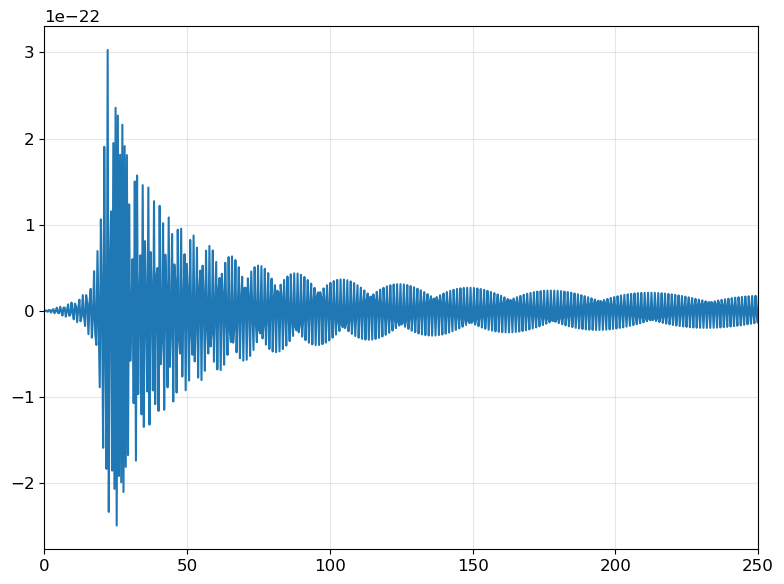

In [10]:
hpf0 = inj_fd_data[:, 1]
hcf0 = inj_fd_data[:, 2]

maxloc = np.argmax(hpf0**2 + hcf0**2)

hf0 = inj_fd_data[:, 0]
# ht0 -= ht0[maxloc]
# ht0 += merger_time

plt.plot(hf0, hpf0)
plt.xlim(0, 250)
plt.show()

In [11]:
# injection dictionary
fdomain_pol_dict = {"plus": hpf0, "cross": hcf0}

# Plot the time domain waveform

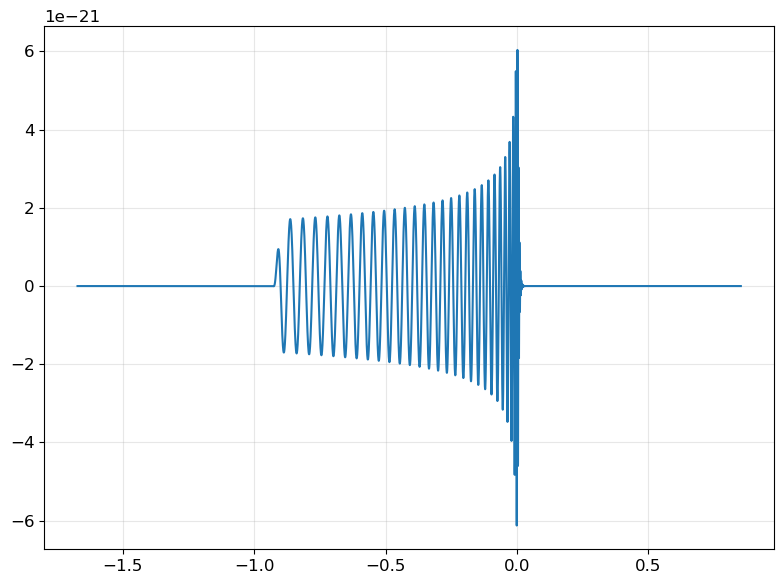

In [12]:
hpt0 = inj_td_data[:, 1]
hct0 = inj_td_data[:, 2]

maxloc = np.argmax(hpt0**2 + hct0**2)


ht0 = inj_td_data[:, 0]
maxtime = ht0[maxloc]
ht0 -= maxtime
# ht0 -= ht0[maxloc]
# ht0 += merger_time

plt.plot(ht0, hpt0)
# plt.xlim(0 ,250)
plt.show()

In [13]:
# injection dictionary
tdomain_pol_dict = {"plus": hpt0, "cross": hct0}

In [14]:
# Specify the output directory and the name of the simulation.
outdir = "outdir_td_inj"
label = f"fast_tutorial_apx_{sim_name}_inj_td_sonic_1"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
# bilby.core.utils.random.seed(88170235)

# Create injection waveform model

In [15]:
def injection_generator(time):
    """
    This function produces the time-domain strain for a given NR-derived signal
    at any given time for a given data.

    Parameters
    ----------
    time : array-like
        A time, or an array of times, at which the amplitudes should be returned.
    """

    # data = np.genfromtxt(datafile)

    hp = np.interp(time, ht0, hpt0)
    hx = np.interp(time, ht0, hct0)

    return {"plus": hp, "cross": hx}

In [16]:
# Create the waveform_generator using a LAL BinaryBlackHole source function
injection_waveform_generator = bilby.gw.WaveformGenerator(
    duration=analysis_duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=injection_generator,
    start_time=merger_time - analysis_duration,
)

18:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.injection_generator
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Create sampler waveform model

In [17]:
# Fixed arguments passed into the source model
sampler_waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_fremass_ratiouency=20.0,
    minimum_frequency=minimum_frequency,
)

In [18]:
# Create the waveform_generator using a LAL BinaryBlackHole source function
sampler_waveform_generator = bilby.gw.WaveformGenerator(
    duration=analysis_duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=sampler_waveform_arguments,
)

18:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Inject the signal

In [19]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=analysis_duration,
    start_time=merger_time - analysis_duration,
)

# new_time = np.linspace(ht0[0], ht0[-1], 4097)

# inj_pol_dict = fdomain_pol_dict#nr_injection(new_time)

print(fdomain_pol_dict["plus"].shape)

# Create a different waveform generator for injection
injection = ifos.inject_signal(
    # injection_polarizations=fdomain_pol_dict,
    waveform_generator=injection_waveform_generator,
    parameters=injection_parameters,
)

print(ifos)

(5172,)


/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
18:51 bilby INFO    : Injected signal in H1:
18:51 bilby INFO    :   optimal SNR = 220.95
18:51 bilby INFO    :   matched filter SNR = 218.19-1.07j
18:51 bilby INFO    :   mass_1 = 40.0
18:51 bilby INFO    :   mass_2 = 20.0
18:51 bilby INFO    :   a_1 = 0.0
18:51 bilby INFO    :   a_2 = 0.0
18:51 bilby INFO  

[Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)]


## Plot ASD

/tmp/ipykernel_3199308/2281181904.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1000)


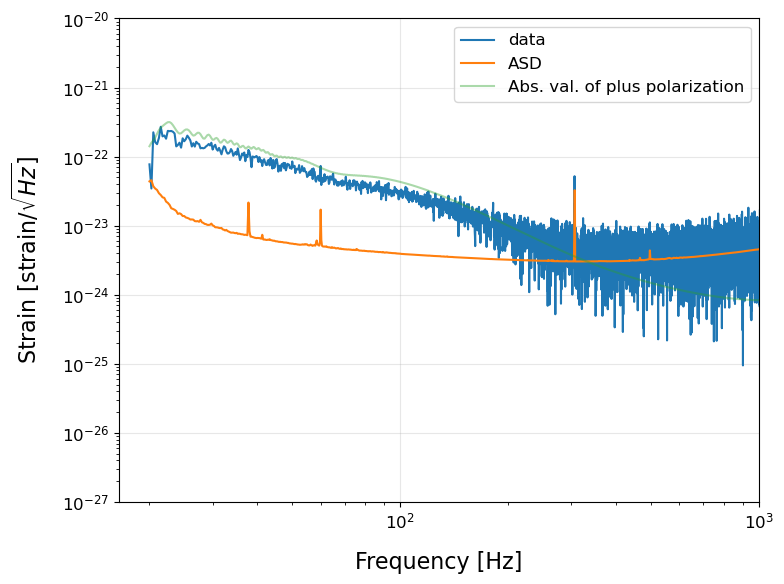

In [20]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = (
    H1.strain_data.frequency_mask
)  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(
    H1.strain_data.frequency_array[idxs],
    np.abs(H1.strain_data.frequency_domain_strain[idxs]),
    label="data",
)
ax.loglog(
    H1.frequency_array[idxs], H1.amplitude_spectral_density_array[idxs], label="ASD"
)
ax.loglog(
    H1.frequency_array[idxs],
    np.abs(H1_injection["plus"][idxs]),
    label="Abs. val. of plus polarization",
    alpha=0.4,
)

ax.set_ylim(1e-27, 1e-20)
ax.set_xlim(0, 1000)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [21]:
H1_injection["plus"][idxs]

array([-1.07745381e-22+9.13325803e-23j, -1.33665283e-22-8.51786282e-23j,
        4.76805276e-23-1.65340677e-22j, ...,
        8.33092124e-25-3.49416537e-28j,  8.33091914e-25-1.74706574e-28j,
        8.33091843e-25+0.00000000e+00j])

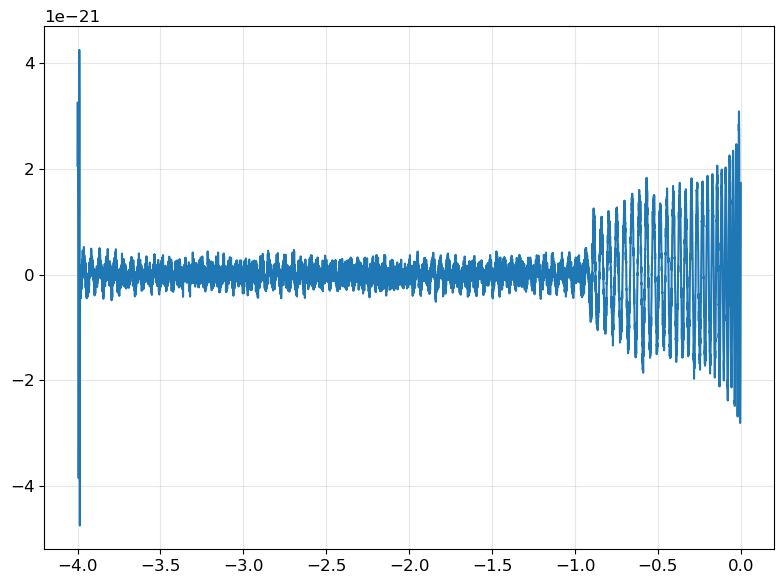

/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


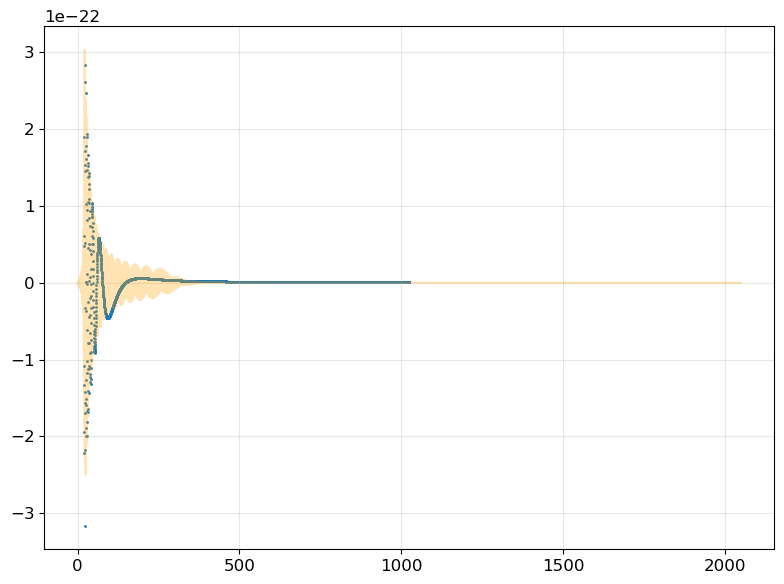

In [22]:
plt.plot(H1.strain_data.time_array, H1.strain_data.time_domain_strain)
plt.show()


plt.scatter(H1.frequency_array[idxs], H1_injection["plus"][idxs], label="inj", s=1)
plt.plot(hf0, hpf0, label="prep", c="orange", alpha=0.3)
# plt.xlim(20, 40)
plt.show()

In [23]:
print(fdomain_pol_dict["plus"].shape)

(5172,)


## Setup priors

In [24]:
# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1, mass_2, theta_jn and luminosity
# distance, which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
from bilby.core.prior import Uniform

priors["chirp_mass"] = Uniform(name="chirp_mass", minimum=15.0, maximum=50)


for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "luminosity_distance",
    "theta_jn",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(analysis_duration, minimum_frequency)

18:51 bilby INFO    : No prior given, using default BBH priors in /mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


True

## Setup likelihood

In [25]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=sampler_waveform_generator,
    time_marginalization=False,
    phase_marginalization=False,
    distance_marginalization=False,
)

In [26]:
injection_parameters["geocent_time"]

0

In [27]:
mass_1, mass_2

(40.0, 20.0)

## Run sampler

In [28]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=1000,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

18:52 bilby INFO    : Running for label 'fast_tutorial_apx_IMRPhenomD_q2_inj_td_sonic_1', output will be saved to 'outdir_td_inj'
18:52 bilby INFO    : Using lal version 7.5.0
18:52 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.5.0;Id: edd3f4e61431c1a0c6a7be13c0be9644be1f6745;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
18:52 bilby INFO    : Using lalsimulation version 5.4.0
18:52 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.4.0;Id: 57c31779c344c6abf3c1d294bab00dd58ed17875;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
18:52 bilby INFO    : Analysis priors:
18:52 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
18:52 bilby INFO    : chirp_mass=Uniform(minimum=15.0, maximum=50, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, b

1it [00:00, ?it/s]

19:03 bilby INFO    : Written checkpoint file outdir_td_inj/fast_tutorial_apx_IMRPhenomD_q2_inj_td_sonic_1_resume.pickle
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gw/lib/python3.11/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(log

20:31 bilby INFO    : Summary of results:
nsamples: 2723
ln_noise_evidence: -27796.249
ln_evidence: -8319.814 +/-  0.157
ln_bayes_factor: 19476.434 +/-  0.157



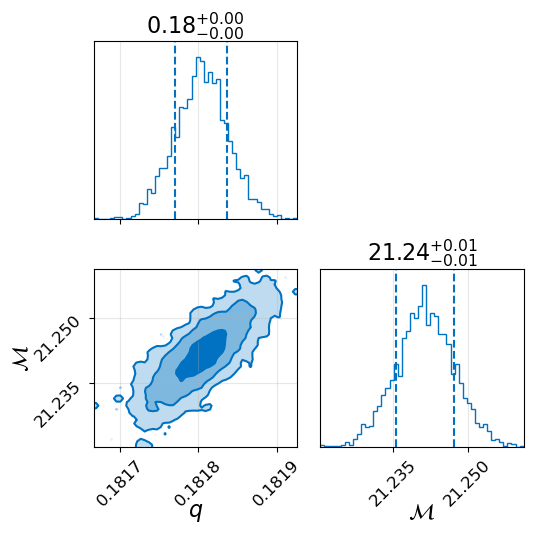

In [29]:
# Make a corner plot.
result.plot_corner()

In [115]:
mass_1

40.0

In [116]:
def ChirpMassFromIndividualMasses(mass_1, mass_2):

    return ((mass_1 * mass_2) ** (3 / 5)) / (mass_1 + mass_2) ** (1 / 5)

In [117]:
Mchirp_act = ChirpMassFromIndividualMasses(mass_1, mass_2)

In [118]:
Mchirp_act

24.334573675728226

In [119]:
mass_1, mass_2

(40.0, 20.0)

In [120]:
bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2)

24.334573675728226

In [121]:
bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(50, mass_ratio)

(82.1875914758613, 41.09379573793065)

In [122]:
bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(100, mass_ratio)

(164.3751829517226, 82.1875914758613)